# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor


Входные данные представляют собой таблицу, состоящую из 10 столбцов:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

# import

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

from datetime import datetime
import re

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [4]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [6]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
Restaurant_id        10000 non-null object
City                 10000 non-null object
Cuisine Style        7693 non-null object
Ranking              10000 non-null float64
Price Range          6525 non-null object
Number of Reviews    9343 non-null float64
Reviews              9998 non-null object
URL_TA               10000 non-null object
ID_TA                10000 non-null object
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [8]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [9]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [10]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
Restaurant_id    10000 non-null object
Rating           10000 non-null float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [11]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [13]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
19455,id_345,Lyon,"['French', 'Bar', 'European']",346.0,$$ - $$$,442.0,"[['Nice quick meal', 'You can do much better i...",/Restaurant_Review-g187265-d3854375-Reviews-Br...,d3854375,1,3.5
4917,id_4917,Vienna,['Cafe'],3002.0,$$ - $$$,6.0,"[[], []]",/Restaurant_Review-g190454-d4706369-Reviews-Al...,d4706369,0,0.0
44356,id_4343,Rome,NaN,4344.0,NaN,17.0,"[[], []]",/Restaurant_Review-g187791-d12067859-Reviews-N...,d12067859,1,4.0
18705,id_1930,Dublin,"['Mexican', 'American', 'European', 'Spanish',...",1937.0,$$ - $$$,NaN,"[['Bottled cocktails?'], ['12/03/2017']]",/Restaurant_Review-g186605-d13124268-Reviews-S...,d13124268,1,2.0
12238,id_150,Paris,"['Italian', 'Pizza', 'European', 'Vegetarian F...",151.0,$$ - $$$,418.0,"[['Amazing', 'Great Italian Restarant'], ['01/...",/Restaurant_Review-g187147-d3784592-Reviews-Pi...,d3784592,1,4.5


In [14]:
data.Reviews[1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

# Cleaning and Prepping Data
Обычно данные содержат в себе кучу мусора, который необходимо почистить, для того чтобы привести их в приемлемый формат. Чистка данных — это необходимый этап решения почти любой реальной задачи.   
![](https://analyticsindiamag.com/wp-content/uploads/2018/01/data-cleaning.png)

## 1. Обработка NAN 
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

Пропуски содержатся в следующих столбцах:
* Cuisine Style
* Price Range
* Number of Reviews
* Reviews

#### Number of Reviews

Числовой признак

In [15]:
data['Number of Reviews NA'] = data['Number of Reviews'].apply(lambda x: 1 if pd.isna(x) else 0)
# заменим NaN для пропусков в 'Number of Reviews' на 0 как наиболее логичное значение 
# для пропуска в данном случае
data['Number of Reviews'].fillna(0, inplace=True)

Проверено, что заполенение пустых значений медианой ухудшает MAE

In [16]:
display(data.loc[:, ['Number of Reviews', 'Number of Reviews NA']].sample(5))
display(data.loc[:, ['Number of Reviews', 'Number of Reviews NA']].info())

,Number of Reviews,Number of Reviews NA
11903,0.0,1
24431,54.0,0
6641,83.0,0
23722,16.0,0
44488,80.0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
Number of Reviews       50000 non-null float64
Number of Reviews NA    50000 non-null int64
dtypes: float64(1), int64(1)
memory usage: 781.4 KB


None

#### Price Range

Ординальный признак, будем переводить в числовой вид.

In [17]:
data['Price Range NA'] = data['Price Range'].apply(lambda x: 1 if pd.isna(x) else 0)

In [18]:
# признак содержит ординальные данные определяющие ценовую категорию
# ресторана, для заполнения выберем наболее распространенную категорию
# - среднюю
display(data['Price Range'].value_counts())
print('price_range mode:', data['Price Range'].mode()[0])

$$ - $$$    23041
$            7816
$$$$         1782
Name: Price Range, dtype: int64

price_range mode: $$ - $$$


In [19]:
data['Price Range'].fillna(data['Price Range'].mode()[0], inplace=True)

In [20]:
display(data.loc[:, ['Price Range', 'Price Range NA']].sample(5))
display(data.loc[:, ['Price Range', 'Price Range NA']].info())

,Price Range,Price Range NA
40219,$$ - $$$,1
46544,$$ - $$$,1
16323,$$ - $$$,1
19408,$$ - $$$,1
6359,$$$$,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
Price Range       50000 non-null object
Price Range NA    50000 non-null int64
dtypes: int64(1), object(1)
memory usage: 781.4+ KB


None

#### Cuisine Style

Категориальный признак

In [21]:
data['Cuisine Style NA'] = data['Cuisine Style'].apply(lambda x: 1 if pd.isna(x) else 0)

In [22]:
data['Cuisine Style NA'].value_counts()
# Заполним пропуски в cuisine во время обработки значений позже..

0    38410
1    11590
Name: Cuisine Style NA, dtype: int64

#### Reviews

In [23]:
data['Reviews NA'] = data['Reviews'].apply(lambda x: 1 if pd.isna(x) else 0)

In [24]:
data['Reviews NA'].value_counts()
# Заполним пропуски в reviews во время обработки значений позже

0    49998
1        2
Name: Reviews NA, dtype: int64

### 2. Обработка признаков и добавление новых
Для начала посмотрим какие признаки у нас могут быть категориальными.

In [25]:
data.nunique(dropna=False)

Restaurant_id           13094
City                       31
Cuisine Style           10732
Ranking                 12975
Price Range                 3
Number of Reviews        1574
Reviews                 41858
URL_TA                  49963
ID_TA                   49963
sample                      2
Rating                     10
Number of Reviews NA        2
Price Range NA              2
Cuisine Style NA            2
Reviews NA                  2
dtype: int64

Какие признаки можно считать категориальными?
* Restaurant_id
* City
* Cuisine Style
* URL_TA
* ID_TA

Как работать с колонками URL_TA и ID_TA, я определить затрудняюсь, поэтому в итоговую модель они включены не будут.    

#### Restaurant_id 

Во вводном разборе было акцентировано внимание на том, что с данным признаком надо разобраться. Посмотрим, уникальны ли айди.

In [26]:
data['Restaurant_id'].value_counts()

id_227      19
id_436      19
id_871      19
id_633      19
id_344      18
            ..
id_11880     1
id_12851     1
id_8782      1
id_12869     1
id_14212     1
Name: Restaurant_id, Length: 13094, dtype: int64

Мы видим, что имеются повторы, значит это не айди конкретного ресторана. Возможно, это сеть. Но я не знаю, как нам можно воспользоваться этой ситуацией для анализа рейтинга.

#### ID_TA

In [27]:
data['ID_TA'].value_counts()
# В данном случае просто покажем, что признак не уникальный

d11698990    2
d5618007     2
d7342803     2
d987900      2
d2669414     2
            ..
d8000931     1
d11767612    1
d8468646     1
d4154169     1
d5577909     1
Name: ID_TA, Length: 49963, dtype: int64

#### URL_TA

In [28]:
data['URL_TA'].value_counts()
# Так же увидели, что признак не уникальный

/Restaurant_Review-g187514-d12488993-Reviews-Kathmandu_Tandoori_House_Nepali_Indian_Cuisine-Madrid.html    2
/Restaurant_Review-g187514-d3685055-Reviews-Shukran-Madrid.html                                            2
/Restaurant_Review-g187514-d8753348-Reviews-Tropecientos-Madrid.html                                       2
/Restaurant_Review-g274856-d10316215-Reviews-Basico_Pizza-Warsaw_Mazovia_Province_Central_Poland.html      2
/Restaurant_Review-g187514-d2360290-Reviews-Lounge_Yi-Madrid.html                                          2
                                                                                                          ..
/Restaurant_Review-g1136497-d10785924-Reviews-Tapassoif-Woluwe_St_Pierre_Brussels.html                     1
/Restaurant_Review-g188644-d2573292-Reviews-La_Favorita-Brussels.html                                      1
/Restaurant_Review-g187147-d7306119-Reviews-Les_Douceurs_de_Port_Royal-Paris_Ile_de_France.html            1
/Restaurant_Review-

#### City

In [29]:
# для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
# Сохраним названия городов - возможно, используем позже (get_dummies это делать, похоже, не умеет)
data['City_name'] = data['City']
data = pd.get_dummies(data, columns=['City'], dummy_na=False)

In [30]:
data.head(5)

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,City_Munich,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich
0,id_0,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,...,0,0,0,1,0,0,0,0,0,0
1,id_1,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,id_2,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,id_3,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,id_4,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
data.sample(5)

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,City_Munich,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich
7338,id_7338,NaN,8703.0,$$ - $$$,8.0,"[['Great little Cafe', 'Mini break to London']...",/Restaurant_Review-g186338-d10643035-Reviews-G...,d10643035,0,0.0,...,0,0,0,0,0,0,0,0,0,0
46925,id_1376,NaN,1378.0,$$ - $$$,2.0,"[['Best little secret on the block.'], ['09/27...",/Restaurant_Review-g806262-d11538820-Reviews-F...,d11538820,1,4.5,...,0,0,0,0,0,0,0,0,0,0
5785,id_5785,"['Italian', 'Pizza', 'Seafood', 'Mediterranean...",2166.0,$$ - $$$,138.0,"[['Consistently enjoyable', 'Mediocre'], ['07/...",/Restaurant_Review-g187849-d1626299-Reviews-Ve...,d1626299,0,0.0,...,0,0,0,0,0,0,0,0,0,0
6879,id_6879,NaN,9765.0,$$ - $$$,47.0,"[['Great food', 'Reasonable but nothing specia...",/Restaurant_Review-g187147-d10681483-Reviews-T...,d10681483,0,0.0,...,0,0,0,1,0,0,0,0,0,0
13520,id_1534,"['Lebanese', 'Mediterranean', 'Middle Eastern'...",1535.0,$,36.0,"[['Really good expensive falafel', 'nice menu ...",/Restaurant_Review-g188644-d6509351-Reviews-Ch...,d6509351,1,4.0,...,0,0,0,0,0,0,0,0,0,0


#### Price Range

In [32]:
data['Price Range'].value_counts()

$$ - $$$    40402
$            7816
$$$$         1782
Name: Price Range, dtype: int64

По описанию 'Price Range' - это ценовой диапазон ресторана.  
Это ординальный признак, т.к. значения можно выстроить по возрастанию. Поэтому заменим обозначения цены соответственно на 1, 2 и 3.

In [33]:
def price_range_to_num(val):
    '''
    Конвертирует строковое значение ценового диапазона на
    числовое, e.g.:
    $:                   1 
    $$-$$$:              2
    в остальных случаях: 3
    Returns:
        Числовое значение соответствующее ценовому диапазону
    '''
    if val == '$':        
        return 1
    elif val == '$$ - $$$':
        return 2
    elif val == '$$$$':
        return 3
    else:
        val
    
    
data['Price Range'] = data['Price Range'].apply(price_range_to_num)

In [34]:
data['Price Range'].value_counts()

2    40402
1     7816
3     1782
Name: Price Range, dtype: int64

> Для некоторых алгоритмов МЛ даже для не категориальных признаков можно применить One-Hot Encoding, и это может улучшить качество модели. Пробуйте разные подходы к кодированию признака - никто не знает заранее, что может взлететь.

Создание dummy-переменных для Price Range не улучшило модель

#### Reviews
Данный признак содержит сложное значение (list of lists) как строку содержащую два последних ревью и даты их опубликования.

In [35]:
data['Reviews'][1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

In [36]:
# сначала пропущенные значения
sum(data['Reviews'].isna())

2

In [37]:
data['Reviews'].fillna('[[], []]', inplace=True)

Оценивать тональность отзывов в данной работе я не буду, так как еще не умею.

На основе дат добавим признаки количества дней между двумя послденими ревью и количество дней с момента последнего ревью

Для того, чтобы вытащить даты, применим регулярное выражение для поиска паттерна даты, а затем используем функцию to_datetime. Проверено, конструкция datetime.strptime(item, '%m/%d/%Y') не обрабатывает одну дату с измененным форматом, поэтому используем to_datetime.

In [38]:
# паттерн для поиска дат
pattern = re.compile('\'\d+\/\d+\/\d+\'')
dates = data['Reviews'].apply(pattern.findall)
# врeменные признаки
data['date1'] = pd.to_datetime(dates.apply(lambda x: x[0] if len(x) > 0 else None))
data['date2'] = pd.to_datetime(dates.apply(lambda x: x[1] if len(x) > 1 else None))

display(data.loc[:, ['date1', 'date2']].sample(5))

,date1,date2
4700,2016-11-14,2016-10-01
4386,2017-11-23,2017-10-23
49081,2017-12-21,2017-12-10
45860,2017-11-05,2017-03-02
10433,2017-12-02,2016-09-12


#### reviews_day_delta & reviews_days_since

In [39]:
def days_since_last_review(r):
    '''
    Считает количество дней с последней даты ревью данной записи
    датасета. Учитывает отсутствие одной из дат и пропуск (возвращает
    0 в последнем случае)
    '''
    datetime_now = datetime.now();
    if pd.notna(r.date1) and pd.notna(r.date2):
        if r.date1 > r.date2:
            return (datetime_now - r.date1).days
        else:
            return (datetime_now - r.date2).days
    else:
        if pd.notna(r.date1):
            return (datetime_now - r.date1).days
        if pd.notna(r.date2):
            return (datetime_now - r.date2).days        
    return 0 


def reviews_days_delta(r):
    '''
    Возвращает количество дней между двумя датами ревью в данной записи
    датасета. Учитывает отсутствие (одной из) дат - возвращает 0 в данном
    случае.
    '''
    if pd.notna(r.date1) and pd.notna(r.date2):
        return abs((r.date1 - r.date2).days)
    else:
        return 0

# новые признаки на основе дат последних ревью: количество дней между
# двумя последними ревью и количество дней со времени последнего ревью
data['Reviews Days Delta'] = data.apply(lambda row: reviews_days_delta(row), axis=1)
data['Reviews Days Since'] = data.apply(lambda row: days_since_last_review(row), axis=1)
# удаляем временные признаки
data.drop(['date1', 'date2'], inplace=True, axis=1)

In [40]:
display(data.sample(5))

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,Reviews Days Delta,Reviews Days Since
42538,id_1940,NaN,1945.0,2,22.0,"[['Lunch at IJ-front', 'Nice location'], ['08/...",/Restaurant_Review-g188590-d1232088-Reviews-Ko...,d1232088,1,4.0,...,0,0,0,0,0,0,0,0,59,1290
12910,id_3886,NaN,3887.0,2,6.0,"[['locl restaurant', 'A hidden heaven in the h...",/Restaurant_Review-g187497-d986345-Reviews-Res...,d986345,1,4.5,...,0,0,0,0,0,0,0,0,1960,1242
47425,id_5303,NaN,5305.0,2,3.0,"[['Nice cafe'], ['06/19/2016']]",/Restaurant_Review-g187323-d1341006-Reviews-Ba...,d1341006,1,4.0,...,0,0,0,0,0,0,0,0,0,1773
27002,id_5252,"['Seafood', 'French']",5253.0,3,106.0,[['Good but there is a comfortable room for i....,/Restaurant_Review-g187147-d4271843-Reviews-A_...,d4271843,1,3.5,...,0,1,0,0,0,0,0,0,22,1497
16928,id_4939,"['Mediterranean', 'Turkish', 'Barbecue', 'Midd...",4948.0,2,79.0,[['One of best Turkish restaurants that I lov....,/Restaurant_Review-g186338-d1062182-Reviews-19...,d1062182,1,4.5,...,0,0,0,0,0,0,0,0,52,1287


#### Ranking
ranking, возможно, полезнее рассматривать в контексте населения города и количества ресторанов в городе - создим новые признаки для этого.

#### Ranking To Rest Num & Ranking To Population

In [41]:
#население территории города (metro area) - источник: wiki
city_population = {'Paris':13024, 'Stockholm':2391, 'London':14257, 
                   'Berlin':6144, 'Munich':5991, 'Oporto':1721,
                   'Milan':4336, 'Bratislava':659, 'Vienna':2600, 
                   'Rome':4342, 'Barcelona':5474, 'Madrid':6791,
                   'Dublin':1417, 'Brussels':2500, 'Zurich':415, 
                   'Warsaw':3100, 'Budapest':3011, 'Copenhagen':2057,
                   'Amsterdam':2480, 'Lyon':2323, 'Hamburg':5107, 
                   'Lisbon':2827, 'Prague':2677, 'Oslo':1588,
                   'Helsinki':1525, 'Edinburgh':901, 'Geneva':201, 
                   'Ljubljana':537, 'Athens':2928,'Luxembourg':633, 
                   'Krakow':1752}

#количество ресторанов в городе - источник: датасет
rest_per_city = data.City_name.value_counts().to_dict()

data['Ranking To Rest Num'] = data.apply(lambda r: (r['Ranking'] / rest_per_city[r.City_name]), axis=1)
data['Ranking To Population'] = data.apply(lambda r: (r['Ranking'] / city_population[r.City_name]), axis=1)
data.sample(5)

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,Reviews Days Delta,Reviews Days Since,Ranking To Rest Num,Ranking To Population
32738,id_8828,NaN,8830.0,2,2.0,"[[], []]",/Restaurant_Review-g187147-d1035196-Reviews-La...,d1035196,1,4.5,...,0,0,0,0,0,0,0,0,1.445645,0.677979
37197,id_891,"['Mediterranean', 'European', 'Spanish', 'Vege...",892.0,2,284.0,"[['Tomato bread', 'Great place!'], ['09/23/201...",/Restaurant_Review-g187497-d7132762-Reviews-Re...,d7132762,1,4.0,...,0,0,0,0,0,0,51,1312,0.262739,0.162952
10377,id_4294,"['French', 'European']",4295.0,2,69.0,"[['Perfect for a simple lunch', 'Delicious'], ...",/Restaurant_Review-g187147-d798936-Reviews-Le_...,d798936,1,4.0,...,0,0,0,0,0,0,169,1209,0.703176,0.329776
42047,id_935,"['Steakhouse', 'Mediterranean', 'European', 'S...",936.0,2,275.0,"[['Really nice ""barrio"" restaurant. Spanish......",/Restaurant_Review-g187514-d2706270-Reviews-Ca...,d2706270,1,4.0,...,0,0,0,0,0,0,71,1325,0.245476,0.137829
20590,id_4717,NaN,4718.0,2,3.0,"[[], []]",/Restaurant_Review-g187497-d9994264-Reviews-Bo...,d9994264,1,4.5,...,0,0,0,0,0,0,0,0,1.389691,0.861893


#### Number Of Reviews
Так же добавим признак выражающий отношение количества ревью к населению (интересно было бы учесть поток туристов, наверное, тоже)

In [42]:
data['Reviews Num To Population'] = data.apply(lambda r: (r['Number of Reviews'] / city_population[r.City_name]), axis=1)

#### Population
Почему бы не добавить и население города как признак

In [43]:
data['Population'] = data.City_name.apply(lambda x: (city_population[x]))

#### Cuisine Style
Содержит строки, состоящие из списка cuisine style. Необходимо решить, что делать с пропущенными значениями и представить данные в формате доступном для ML.
Dummy'фикация cuisine не дала значительного улучшения MAE, как и другие попытки. Решено оставить данный признак.

In [44]:
# Заменим пропуски на Unknown
data['Cuisine Style'].fillna('Unknown', inplace=True)

In [45]:
# Выполним преобразование данных в колонке. Нам нужно получить список кухонь для каждого ресторана,
# чтобы посчитать их количество
data['Cuisine Style'] = data['Cuisine Style'].apply(lambda x: x.replace('[',''))
data['Cuisine Style'] = data['Cuisine Style'].apply(lambda x: x.replace(']',''))
data['Cuisine Style'] = data['Cuisine Style'].apply(lambda x: x.replace(' ',''))
data['Cuisines List'] = data['Cuisine Style'].apply(lambda x: x.split(','))

In [46]:
# Создадим признак, содержащий количество кухонь, представленных в ресторане
data['Cuisines Number'] = data['Cuisines List'].apply(lambda x: len(x))

#### Restaurant_id

In [47]:
# Проверим уникальность значений в колонке
data['Restaurant_id'].value_counts()

id_227      19
id_436      19
id_871      19
id_633      19
id_344      18
            ..
id_11880     1
id_12851     1
id_8782      1
id_12869     1
id_14212     1
Name: Restaurant_id, Length: 13094, dtype: int64

Некоторые значения не уникальны, возможно, это сеть ресторанов, но у меня нет идей по преобразованию в категориальный признак

#### Reviews per City

In [48]:
# Создадим признак с количеством отзывов на городов
reviews_per_city = data.groupby('City_name')['Number of Reviews'].mean()
data['Reviews per City'] = data['City_name'].apply(lambda x: reviews_per_city[x])

In [49]:
data['Reviews per City']

0        111.464800
1         62.128421
2        231.010738
3        129.816488
4         43.873684
            ...    
49995    160.115071
49996    111.464800
49997     69.301065
49998     60.147027
49999    160.115071
Name: Reviews per City, Length: 50000, dtype: float64

#### Ranking per City

In [50]:
# Создадим признак со средним рангом по городам
ranking_per_city = data.groupby('City_name')['Ranking'].mean()
data['Ranking per City'] = data['City_name'].apply(lambda x: ranking_per_city[x])

In [51]:
data['Ranking per City']

0        6938.557138
1         564.231579
2         885.130201
3        8169.707354
4         462.428947
            ...     
49995    3106.027840
49996    6938.557138
49997    1237.482091
49998    1055.193514
49999    3106.027840
Name: Ranking per City, Length: 50000, dtype: float64

Данный признак не улучшил оценку, в итоговой модели его не будет

#### Purchasing Power Index

In [52]:
# Создадим признак на основе рейтинга 2018 года
purchasing_power_index = {
        'London' : 24,
        'Paris' : 22,
        'Madrid' : 23,
        'Barcelona' : 30,
        'Berlin' : 8,
        'Milan' : 40,
        'Rome' : 37,
        'Prague' : 31,
        'Lisbon' : 48,
        'Vienna' : 21,
        'Amsterdam' : 19,
        'Brussels' : 15,
        'Hamburg' : 7,
        'Munich' : 6,
        'Lyon' : 70,
        'Stockholm' : 13,
        'Budapest' : 51,
        'Warsaw' : 29,
        'Dublin' : 27,
        'Copenhagen' : 10,
        'Athens' : 53,
        'Edinburgh' : 16, 
        'Zurich' : 2,
        'Oporto' : 42,
        'Geneva' : 3, 
        'Krakow' : 36, 
        'Oslo' : 17, 
        'Helsinki' : 9,
        'Bratislava' : 39,
        'Luxembourg' : 4,
        'Ljubljana' : 32
    }
data['Purchasing Power'] = data['City_name'].apply(lambda x: purchasing_power_index[x])

In [53]:
data['Purchasing Power']

0        22
1         9
2        16
3        24
4        39
         ..
49995    40
49996    22
49997    13
49998    29
49999    40
Name: Purchasing Power, Length: 50000, dtype: int64

#### Is Capital

In [54]:
# Создадим признак, означающий, является ли город столицей
    is_capital_dict = {
        'Paris': 1,
        'Stockholm': 1,
        'London': 1,
        'Berlin': 1,
        'Munich': 0,
        'Oporto': 0,
        'Milan': 0,
        'Bratislava': 1,
        'Vienna': 1,
        'Rome': 1,
        'Barcelona': 0,
        'Madrid': 1,
        'Dublin': 1,
        'Brussels': 1,
        'Zurich': 0,
        'Warsaw': 1,
        'Budapest': 1,
        'Copenhagen': 1,
        'Amsterdam': 1,
        'Lyon': 0,
        'Hamburg': 0,
        'Lisbon': 1,
        'Prague': 1,
        'Oslo': 1,
        'Helsinki': 1,
        'Edinburgh': 1,
        'Geneva': 0,
        'Ljubljana': 1,
        'Athens': 1,
        'Luxembourg': 1,
        'Krakow': 0
    }

    data['Is Capital'] = data['City_name'].apply(lambda x: is_capital_dict[x])

In [55]:
data[['City_name', 'Is Capital']]

,City_name,Is Capital
0,Paris,1
1,Helsinki,1
2,Edinburgh,1
3,London,1
4,Bratislava,1
...,...,...
49995,Milan,0
49996,Paris,1
49997,Stockholm,1
49998,Warsaw,1


# EDA 

### Посмотрим распределение признака

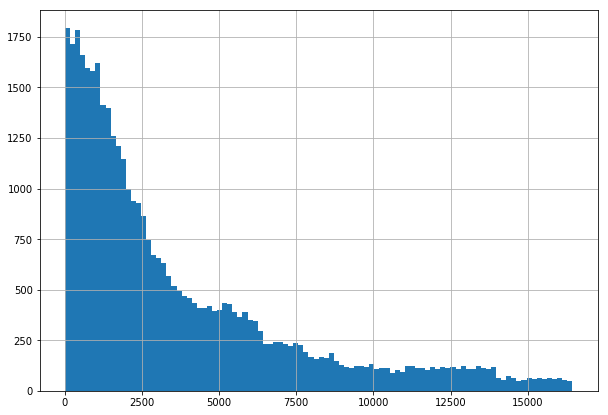

In [56]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

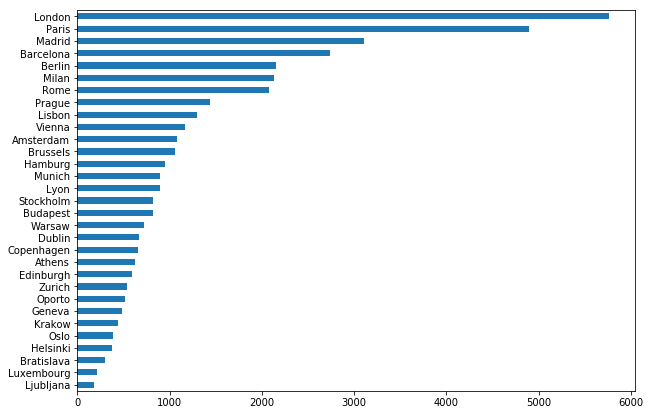

In [57]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

А кто-то говорил, что французы любят поесть=) Посмотрим, как изменится распределение в большом городе:

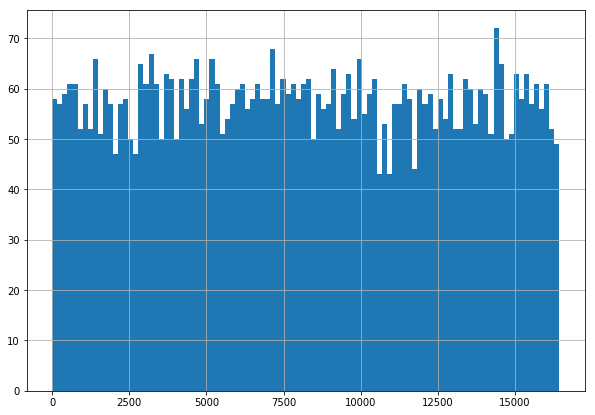

In [58]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

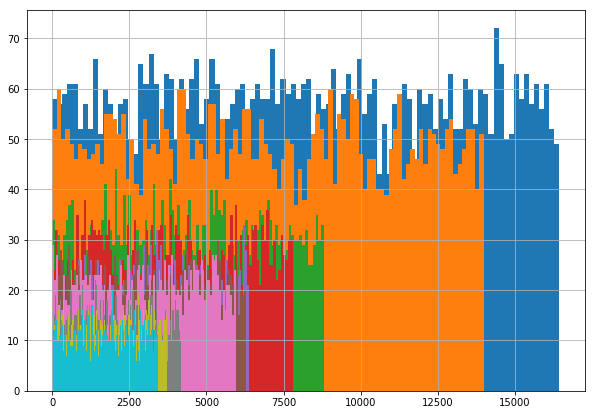

In [59]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.


### Посмотрим распределение целевой переменной

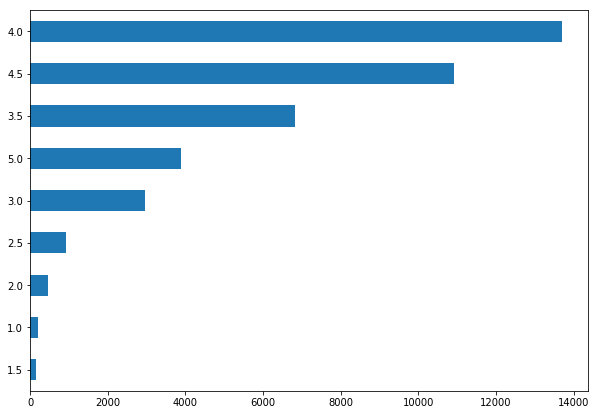

In [60]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

Наибольшее количество ресторанов имеют рейтинг 4.

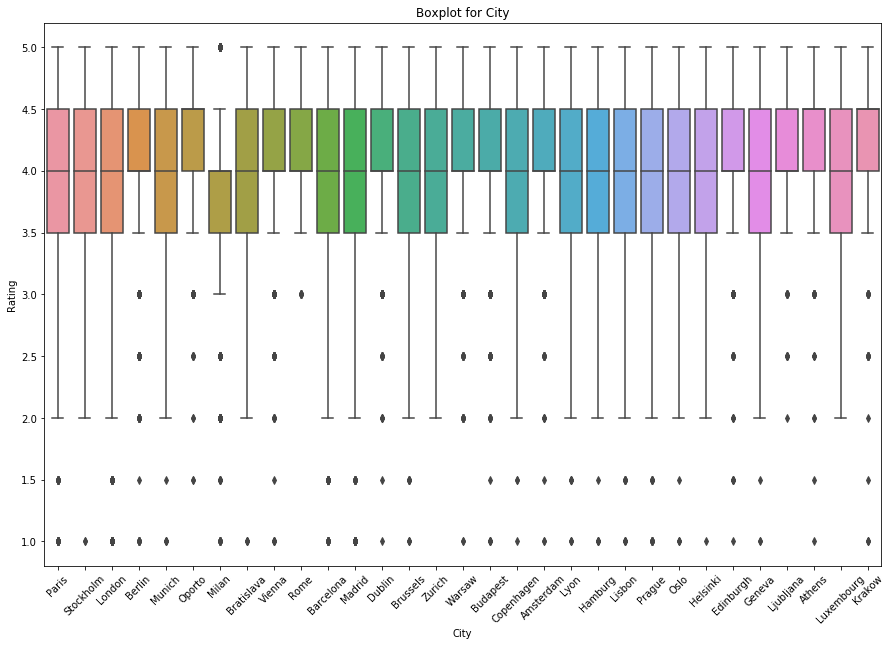

In [61]:
# Построим боксплоты для рейтинга
fig, ax = plt.subplots(figsize = (15, 10))

sns.boxplot(x = 'City', y = 'Rating',data=df_train)

plt.xticks(rotation=45)
ax.set_title('Boxplot for City')

plt.show()

Рестораны Милана заметно отличаются распределением оценок. Если посмотреть данные по ресторанам, имеющим пустые отзывы и максимальный балл, появляется мысль о том, что рейтинги могут быть ненастоящие.

In [62]:
df_train[(df_train['City'] == 'Milan') & (df_train['Rating'] == 5) & 
         (df_train['Reviews'] == '[[], []]')]

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample
879,id_2711,Milan,"['Italian', 'Bar', 'Pub']",2713.0,5.0,$,6.0,"[[], []]",/Restaurant_Review-g187849-d12078773-Reviews-K...,d12078773,1
2722,id_3389,Milan,['Italian'],3391.0,5.0,NaN,2.0,"[[], []]",/Restaurant_Review-g187849-d4409952-Reviews-Ba...,d4409952,1
3008,id_3100,Milan,['Italian'],3102.0,5.0,$,4.0,"[[], []]",/Restaurant_Review-g187849-d11964352-Reviews-B...,d11964352,1
3481,id_1712,Milan,"['Italian', 'Mediterranean']",1714.0,5.0,$,12.0,"[[], []]",/Restaurant_Review-g187849-d12972191-Reviews-F...,d12972191,1
4194,id_3455,Milan,NaN,3457.0,5.0,NaN,NaN,"[[], []]",/Restaurant_Review-g187849-d10045197-Reviews-L...,d10045197,1
...,...,...,...,...,...,...,...,...,...,...,...
36124,id_2716,Milan,"['Italian', 'International', 'Vegan Options']",2718.0,5.0,$$ - $$$,5.0,"[[], []]",/Restaurant_Review-g187849-d10816049-Reviews-I...,d10816049,1
36157,id_3071,Milan,"['Bar', 'Pizza', 'Pub']",3073.0,5.0,$,10.0,"[[], []]",/Restaurant_Review-g187849-d9748695-Reviews-Ha...,d9748695,1
37003,id_3074,Milan,NaN,3076.0,5.0,NaN,9.0,"[[], []]",/Restaurant_Review-g187849-d5813931-Reviews-Sa...,d5813931,1
37900,id_3580,Milan,"['Belgian', 'Dutch', 'Fast Food', 'European', ...",3582.0,5.0,$,4.0,"[[], []]",/Restaurant_Review-g187849-d10637942-Reviews-P...,d10637942,1


### Посмотрим распределение целевой переменной относительно признака

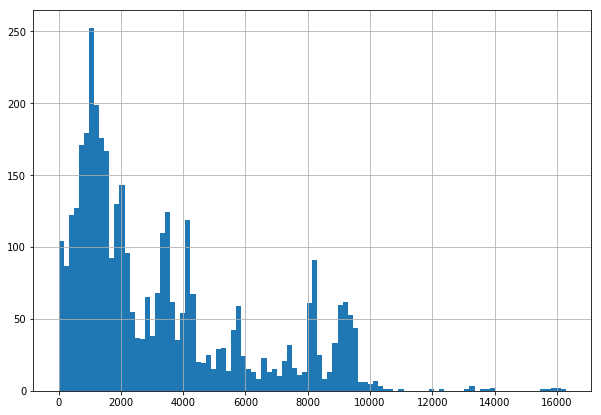

In [63]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

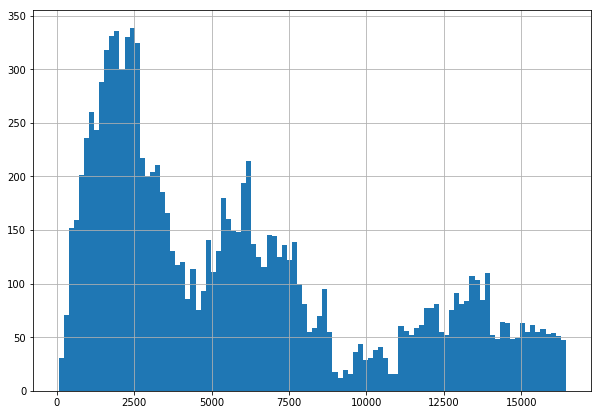

In [64]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

### Посмотрим зависимость ранга от количества отзывов

Text(0, 0.5, 'Ранг ресторана')

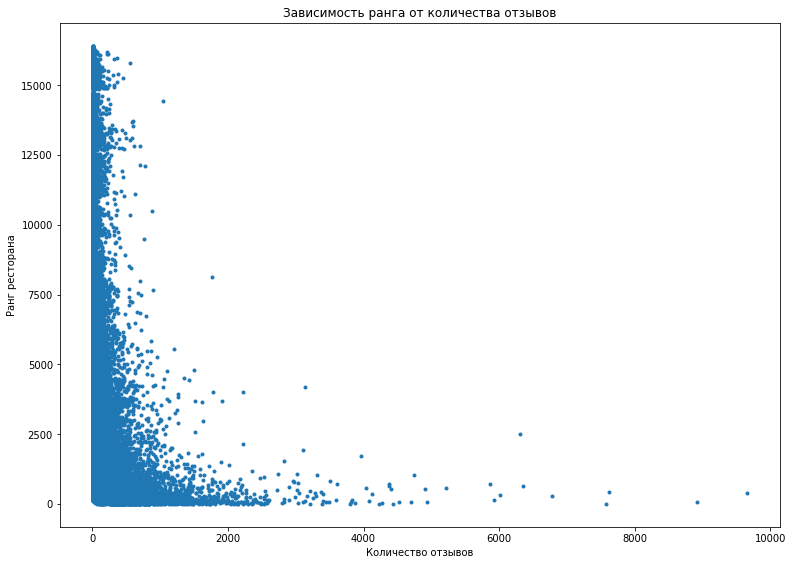

In [65]:
fig = plt.figure()
axes = fig.add_axes([0, 0, 1, 1])
axes.scatter(x = df_train['Number of Reviews'], y = df_train['Ranking'], marker = '.')
axes.set_title('Зависимость ранга от количества отзывов')
axes.set_xlabel('Количество отзывов')
axes.set_ylabel('Ранг ресторана')

### И один из моих любимых - [корреляция признаков](https://ru.wikipedia.org/wiki/Корреляция)
На этом графике уже сейчас вы сможете заметить, как признаки связаны между собой и с целевой переменной.

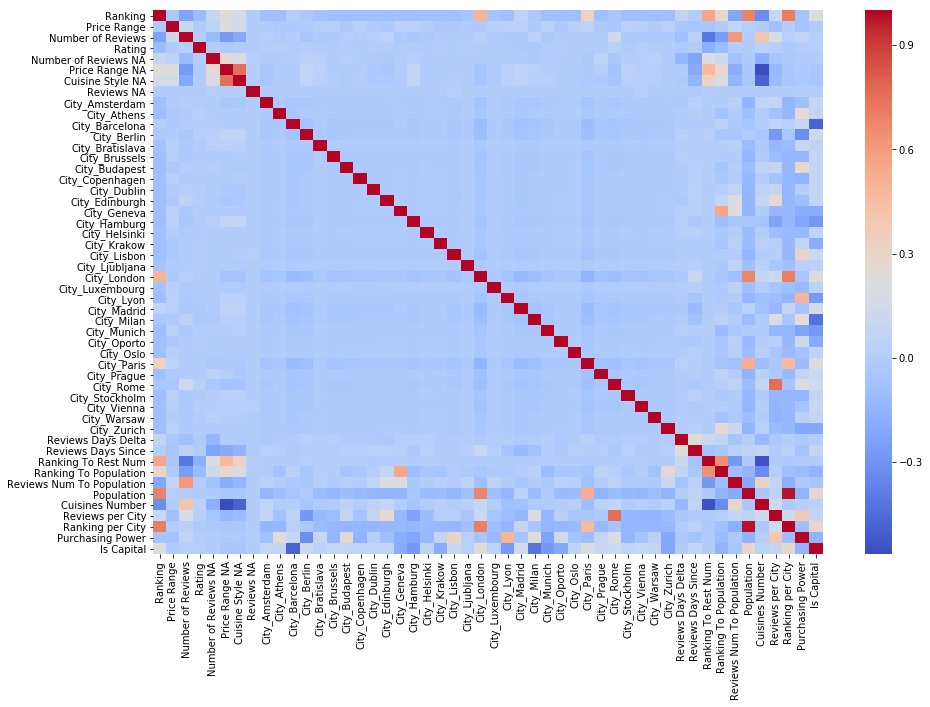

In [66]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(), cmap='coolwarm')

# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [67]:
# на всякий случай, заново подгружаем данные
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [68]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    df_output.drop(['Restaurant_id','ID_TA',], axis = 1, inplace=True)
    
    # ################### 2. NAN ############################################################## 
    # Далее заполняем пропуски, вы можете попробовать заполнением средним или средним по городу и тд...
    df_output['Number of Reviews NA'] = df_output['Number of Reviews'].apply(lambda x: 1 if pd.isna(x) else 0)
    # заменим NaN для пропусков в 'Number of Reviews' на 0 как наиболее логичное значение 
    # для пропуска в данном случае
    df_output['Number of Reviews'].fillna(0, inplace=True)  
    # df_output['Number of Reviews'].fillna(df_output['Number of Reviews'].median(), inplace=True)  
    
    df_output['Price Range NA'] = df_output['Price Range'].apply(lambda x: 1 if pd.isna(x) else 0)
    # признак содержит ординальные данные определяющие ценовую категорию ресторана, для 
    # заполнения выберем наболее распространенную категорию - среднюю
    df_output['Price Range'].fillna(df_output['Price Range'].mode()[0], inplace=True)
    
    df_output['Cuisine Style NA'] = df_output['Cuisine Style'].apply(lambda x: 1 if pd.isna(x) else 0)
    # Заполним пропуски в cuisine во время обработки значений позже..
    df_output['Cuisine Style'].fillna('Unknown', inplace=True)
   
    # Выполним преобразование данных в колонке. Нам нужно получить список кухонь для каждого ресторана,
    # чтобы посчитать их количество
    df_output['Cuisine Style'] = df_output['Cuisine Style'].apply(lambda x: x.replace('[',''))
    df_output['Cuisine Style'] = df_output['Cuisine Style'].apply(lambda x: x.replace(']',''))
    df_output['Cuisine Style'] = df_output['Cuisine Style'].apply(lambda x: x.replace(' ',''))
    df_output['Cuisines List'] = df_output['Cuisine Style'].apply(lambda x: x.split(','))
    # Создадим признак, содержащий количество кухонь, представленных в ресторане
    df_output['Cuisines Number'] = df_output['Cuisines List'].apply(lambda x: len(x))
    
    df_output['Reviews NA'] = df_output['Reviews'].apply(lambda x: 1 if pd.isna(x) else 0)
    df_output['Reviews'].fillna('[[], []]', inplace=True)
    
    
    # ################### 3. Encoding ############################################################## 
    # для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
    # Сохраним названия городов - возможно, используем позже (get_dummies это делать, похоже, не умеет)
    df_output['City_name'] = df_output['City']
    df_output = pd.get_dummies(df_output, columns=['City'], dummy_na=False)
    
    def price_range_to_num(val):
        '''
        Конвертирует строковое значение ценового диапазона на
        числовое, e.g.:
        $:                   1 
        $$-$$$:              2
        в остальных случаях: 3
        Returns:
            Числовое значение соответствующее ценовому диапазону
        '''
        if val == '$':        
            return 1
        elif val == '$$ - $$$':
            return 2
        elif val == '$$$$':
            return 3
        else:
            val
        
    df_output['Price Range'] = df_output['Price Range'].apply(price_range_to_num)
    # df_output = pd.get_dummies(df_output, columns=['Price Range'], dummy_na=False)
    
    # ################### 4. Feature Engineering ####################################################
    # тут ваш код не генерацию новых фитчей
    # ....
    # паттерн для поиска дат
    pattern = re.compile('\'\d+\/\d+\/\d+\'')
    dates = df_output['Reviews'].apply(pattern.findall)
    # врeменные признаки
    df_output['date1'] = pd.to_datetime(dates.apply(lambda x: x[0] if len(x) > 0 else None))
    df_output['date2'] = pd.to_datetime(dates.apply(lambda x: x[1] if len(x) > 1 else None))
    
    def days_since_last_review(r):
        '''
        Считает количество дней с последней даты ревью данной записи
        датасета. Учитывает отсутствие одной из дат и пропуск (возвращает
        0 в последнем случае)
        '''
        datetime_now = datetime.now();
        if pd.notna(r.date1) and pd.notna(r.date2):
            if r.date1 > r.date2:
                return (datetime_now - r.date1).days
            else:
                return (datetime_now - r.date2).days
        else:
            if pd.notna(r.date1):
                return (datetime_now - r.date1).days
            if pd.notna(r.date2):
                return (datetime_now - r.date2).days        
        return 0 


    def reviews_days_delta(r):
        '''
        Возвращает количество дней между двумя датами ревью в данной записи
        датасета. Учитывает отсутствие (одной из) дат - возвращает 0 в данном
        случае.
        '''
        if pd.notna(r.date1) and pd.notna(r.date2):
            return abs((r.date1 - r.date2).days)
        else:
            return 0
    
    df_output['Reviews Days Delta'] = df_output.apply(lambda row: reviews_days_delta(row), axis=1)
    df_output['Reviews Days Since'] = df_output.apply(lambda row: days_since_last_review(row), axis=1)
    # удаляем временные признаки
    df_output.drop(['date1', 'date2'], inplace=True, axis=1)
    
    #население территории города (metro area) - источник: wiki
    city_population = {'Paris':13024, 'Stockholm':2391, 'London':14257, 
                       'Berlin':6144, 'Munich':5991, 'Oporto':1721,
                       'Milan':4336, 'Bratislava':659, 'Vienna':2600, 
                       'Rome':4342, 'Barcelona':5474, 'Madrid':6791,
                       'Dublin':1417, 'Brussels':2500, 'Zurich':415, 
                       'Warsaw':3100, 'Budapest':3011, 'Copenhagen':2057,
                       'Amsterdam':2480, 'Lyon':2323, 'Hamburg':5107, 
                       'Lisbon':2827, 'Prague':2677, 'Oslo':1588,
                       'Helsinki':1525, 'Edinburgh':901, 'Geneva':201, 
                       'Ljubljana':537, 'Athens':2928,'Luxembourg':633, 
                       'Krakow':1752}
    
    # количество ресторанов в городе - источник: датасет
    rest_per_city = df_output.City_name.value_counts().to_dict()
    
    df_output['Ranking To Rest Num'] = df_output.apply(lambda r: (r['Ranking'] / rest_per_city[r.City_name]), axis=1)
    df_output['Ranking To Population'] = df_output.apply(lambda r: (r['Ranking'] / city_population[r.City_name]), axis=1) 
    df_output['Reviews Num To Population'] = df_output.apply(lambda r: (r['Number of Reviews'] / city_population[r.City_name]), axis=1)
    df_output['Population'] = df_output.City_name.apply(lambda x: (city_population[x]))
    # df_output['Rest per city'] = df_output.apply(lambda x: rest_per_city[x.City_name], axis = 1)
    
    # Создадим признак с количеством отзывов на город
    reviews_per_city = df_output.groupby('City_name')['Number of Reviews'].mean()
    df_output['Reviews per City'] = df_output['City_name'].apply(lambda x: reviews_per_city[x])
    
    # Создадим признак со средним рангом по городам
    # ranking_per_city = df_output.groupby('City_name')['Ranking'].mean()
    # df_output['Ranking per City'] = df_output['City_name'].apply(lambda x: ranking_per_city[x])
 
    # Создадим признак Purchasing Power Index на основе рейтинга 2018 года
    purchasing_power_index = {
            'London' : 24,
            'Paris' : 22,
            'Madrid' : 23,
            'Barcelona' : 30,
            'Berlin' : 8,
            'Milan' : 40,
            'Rome' : 37,
            'Prague' : 31,
            'Lisbon' : 48,
            'Vienna' : 21,
            'Amsterdam' : 19,
            'Brussels' : 15,
            'Hamburg' : 7,
            'Munich' : 6,
            'Lyon' : 70,
            'Stockholm' : 13,
            'Budapest' : 51,
            'Warsaw' : 29,
            'Dublin' : 27,
            'Copenhagen' : 10,
            'Athens' : 53,
            'Edinburgh' : 16, 
            'Zurich' : 2,
            'Oporto' : 42,
            'Geneva' : 3, 
            'Krakow' : 36, 
            'Oslo' : 17, 
            'Helsinki' : 9,
            'Bratislava' : 39,
            'Luxembourg' : 4,
            'Ljubljana' : 32
        }
    df_output['Purchasing Power'] = df_output['City_name'].apply(lambda x: purchasing_power_index[x])
    
    # Создадим признак IsCapital
    is_capital_dict = {
        'Paris': 1,
        'Stockholm': 1,
        'London': 1,
        'Berlin': 1,
        'Munich': 0,
        'Oporto': 0,
        'Milan': 0,
        'Bratislava': 1,
        'Vienna': 1,
        'Rome': 1,
        'Barcelona': 0,
        'Madrid': 1,
        'Dublin': 1,
        'Brussels': 1,
        'Zurich': 0,
        'Warsaw': 1,
        'Budapest': 1,
        'Copenhagen': 1,
        'Amsterdam': 1,
        'Lyon': 0,
        'Hamburg': 0,
        'Lisbon': 1,
        'Prague': 1,
        'Oslo': 1,
        'Helsinki': 1,
        'Edinburgh': 1,
        'Geneva': 0,
        'Ljubljana': 1,
        'Athens': 1,
        'Luxembourg': 1,
        'Krakow': 0
    }

    df_output['Is Capital'] = df_output['City_name'].apply(lambda x: is_capital_dict[x])
    
    # ################### 5. Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
    object_columns = [s for s in df_output.columns if df_output[s].dtypes == 'object']
    df_output.drop(object_columns, axis = 1, inplace=True)
    
    return df_output

#### Запускаем и проверяем что получилось

In [69]:
df_preproc = preproc_data(data)
df_preproc.sample(10)

,Ranking,Price Range,Number of Reviews,sample,Rating,Number of Reviews NA,Price Range NA,Cuisine Style NA,Cuisines Number,Reviews NA,...,City_Zurich,Reviews Days Delta,Reviews Days Since,Ranking To Rest Num,Ranking To Population,Reviews Num To Population,Population,Reviews per City,Purchasing Power,Is Capital
14890,1781.0,1,5.0,1,4.0,0,0,0,1,0,...,0,147,1492,2.130383,1.256881,0.003529,1417,146.894737,27,1
8358,1717.0,2,92.0,0,0.0,0,0,0,2,0,...,0,241,1214,1.499563,0.286597,0.015356,5991,71.952838,6,0
49165,507.0,2,472.0,1,4.5,0,0,0,5,0,...,0,30,1218,0.083006,0.038928,0.036241,13024,111.464800,22,1
34555,590.0,2,0.0,1,4.0,1,1,1,1,0,...,0,0,0,1.552632,0.895296,0.000000,659,43.873684,39,1
44086,2346.0,2,34.0,1,3.5,0,0,0,5,0,...,0,14,1356,1.291850,0.876354,0.012701,2677,110.063326,31,1
30424,2470.0,2,7.0,1,3.5,0,1,1,1,0,...,0,0,0,2.157205,0.412285,0.001168,5991,71.952838,6,0
11603,2613.0,2,14.0,1,2.0,0,1,1,1,0,...,0,0,1745,2.320604,1.124839,0.006027,2323,83.438721,70,0
47002,4838.0,2,61.0,1,4.0,0,0,0,1,0,...,0,233,1314,0.672598,0.339342,0.004279,14257,129.816488,24,1
9796,1825.0,3,4.0,0,0.0,0,0,0,1,0,...,0,2138,2656,1.620782,0.785622,0.001722,2323,83.438721,70,0
4068,1815.0,2,0.0,0,0.0,1,1,1,1,0,...,0,0,2414,1.257796,0.698077,0.000000,2600,73.949411,21,1


In [70]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 50 columns):
Ranking                      50000 non-null float64
Price Range                  50000 non-null int64
Number of Reviews            50000 non-null float64
sample                       50000 non-null int64
Rating                       50000 non-null float64
Number of Reviews NA         50000 non-null int64
Price Range NA               50000 non-null int64
Cuisine Style NA             50000 non-null int64
Cuisines Number              50000 non-null int64
Reviews NA                   50000 non-null int64
City_Amsterdam               50000 non-null uint8
City_Athens                  50000 non-null uint8
City_Barcelona               50000 non-null uint8
City_Berlin                  50000 non-null uint8
City_Bratislava              50000 non-null uint8
City_Brussels                50000 non-null uint8
City_Budapest                50000 non-null uint8
City_Copenhagen              50000 

In [71]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [72]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [73]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 49), (40000, 49), (40000, 48), (32000, 48), (8000, 48))

# Model 
Сам ML

In [74]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [75]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [76]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [77]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.19908999999999996


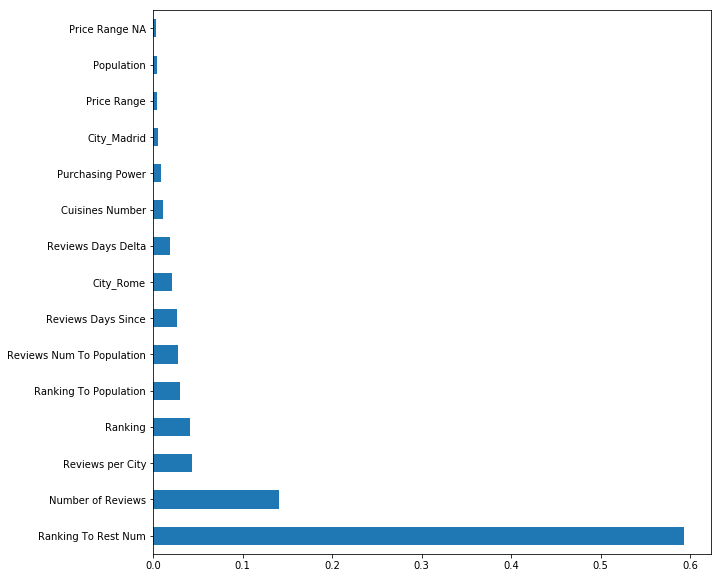

In [78]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [79]:
test_data.sample(10)

,Ranking,Price Range,Number of Reviews,Rating,Number of Reviews NA,Price Range NA,Cuisine Style NA,Cuisines Number,Reviews NA,City_Amsterdam,...,City_Zurich,Reviews Days Delta,Reviews Days Since,Ranking To Rest Num,Ranking To Population,Reviews Num To Population,Population,Reviews per City,Purchasing Power,Is Capital
6528,3579.0,2,52.0,0.0,0,0,0,2,0,0,...,0,154,1765,0.585953,0.274800,0.003993,13024,111.464800,22,1
5085,2393.0,2,21.0,0.0,0,1,1,1,0,0,...,0,3,1281,2.343781,0.794753,0.006974,3011,145.314398,51,1
4702,2842.0,2,114.0,0.0,0,0,0,3,0,0,...,0,94,1266,2.162861,1.136800,0.045600,2500,86.724505,15,1
2781,773.0,2,4.0,0.0,0,1,0,1,0,0,...,0,577,2154,1.627368,0.506885,0.002623,1525,62.128421,9,1
9834,871.0,2,24.0,0.0,0,0,0,3,0,0,...,0,38,1209,0.479626,0.325364,0.008965,2677,110.063326,31,1
1513,2698.0,2,2.0,0.0,0,1,1,1,0,0,...,0,0,1420,2.274874,0.528294,0.000392,5107,41.191400,7,0
5533,10969.0,2,4.0,0.0,0,1,1,1,0,0,...,0,0,0,1.795842,0.842214,0.000307,13024,111.464800,22,1
4433,64.0,1,78.0,0.0,0,0,0,5,0,0,...,0,14,1282,0.288288,0.119181,0.145251,537,82.292793,32,1
3416,1525.0,2,10.0,0.0,0,1,1,1,0,0,...,0,22,1705,2.046980,1.692564,0.011099,901,231.010738,16,1
5584,534.0,2,16.0,0.0,0,0,0,1,0,0,...,0,370,1231,1.094262,0.336272,0.010076,1588,95.495902,17,1


In [80]:
test_data = test_data.drop(['Rating'], axis=1)

In [81]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [82]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [83]:
predict_submission

array([3.07 , 4.2  , 4.51 , ..., 3.005, 4.49 , 4.435])

In [84]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.070
1,id_1,4.200
2,id_2,4.510
3,id_3,4.310
4,id_4,4.490
5,id_5,4.445
6,id_6,3.025
7,id_7,2.275
8,id_8,4.085
9,id_9,4.595


#### **Общие впечателения от работы.**
В целом проект интересный, видно реальное применение DS. Но работа вызвала много затруднений вследствие того, что все в этом курсе я изучаю с нуля.

Не хватает опыта именно в изобретении новых фич. Не совсем понятно, как к этому подходить. Возможно, у этого есть какие-то научные основы, хотелось бы что-то изучить дополнительно. 

Так же чувствую затруднения с выбором способа визуализации и трактовкой результатов. Опять же хотелось бы какие-то материалы на эту тему, чтобы стало понятнее, как с этим работать на практике. 

Результат MAE в рейтинговой таблице (0.20463) отличается от полученного в блокноте (0.19909).

Интересно, есть ли в реальной практике какие-то правила или рекомендации относительно того, как глубоко надо закапываться в генерацию признаков, и есть ли минимальная приемлемая точность для того, чтобы считать задачу выполненной. 